## Import Packages

In [1]:
import os
import gc
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import nltk
from nltk.tokenize import TweetTokenizer, PunktSentenceTokenizer
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')

from time import time 
from functools import partial
from tqdm.notebook import tqdm
from pprint import pprint

from transformers import AutoTokenizer, AutoModel
from datasets import Dataset as HF_Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, cohen_kappa_score

from scipy.special import softmax

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.2.1
CUDA Available: True
CUDA Version: 11.8


In [2]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger


In [3]:
# Global Var

platform = '.' # '/kaggle' or '.'

TRAIN_CSV = f'{platform}/input/learning-agency-lab-automated-essay-scoring-2/train.csv'
MODEL_DIR = f'{platform}/input/huggingfacedebertav3variants'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


In [4]:
class TRAIN_CONFIG:
    MODEL_NAME="DeBerta_base_MaxPool_HiddenStates"
    OUTPUT_DIR=f"{platform}/working"
    N_CLASSES=6
    N_SPLITS=5
    MAX_LENGTH=512
    EMBEDDING_SIZE = 768
    DEBERTA_PATH = f"{MODEL_DIR}/deberta-v3-base"
    USE_SCORE_WEIGHTS = np.array([1, 5, 6, 5, 2, 0.5]) #np.array([1, 1, 1, 1, 1, 1]) #
    BATCH_SIZE = 8
    EPOCHS = 5 #5
    MAX_LR = 1e-5
    LR_FINAL_DIV= 1000
    PRINT_EPOCH_FREQ = 1
    NUM_WORKERS = 0
    AMP = True
    GRADIENT_ACCUMULATION_STEPS = 1
    PRINT_FREQ = None
    WEIGHT_DECAY = 0.02
    MAX_GRAD_NORM = 1e7
    SEED = 2046

In [5]:
def seed_everything(seed):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# fix random seed
seed_everything(seed=TRAIN_CONFIG.SEED)

# Load Data

Load CSV, convert to tokens, and generate embedding.

In [6]:
train_csv = pd.read_csv(TRAIN_CSV, nrows=None)
train_csv['label'] = train_csv['score'] - 1
train_csv['text_length'] = train_csv['full_text'].apply(lambda x: len(x.split()))

print("train_csv shape = ", train_csv.shape)

train_csv.sort_values('text_length', ascending=False).head()

train_csv shape =  (17307, 5)


,essay_id,full_text,score,label,text_length
2155,20cb752,I thought it might be boring and a lot of work...,2,1,1656
8609,7fe2d12,"To the state and the state's country, the elec...",6,5,1367
15824,e9831f4,When limiting car usage the first thing that m...,6,5,1351
2803,29daf40,As the global concern for the environment incr...,5,4,1312
5158,4d00492,"Dear Senator,\n\nConcerning the topic of the m...",6,5,1302


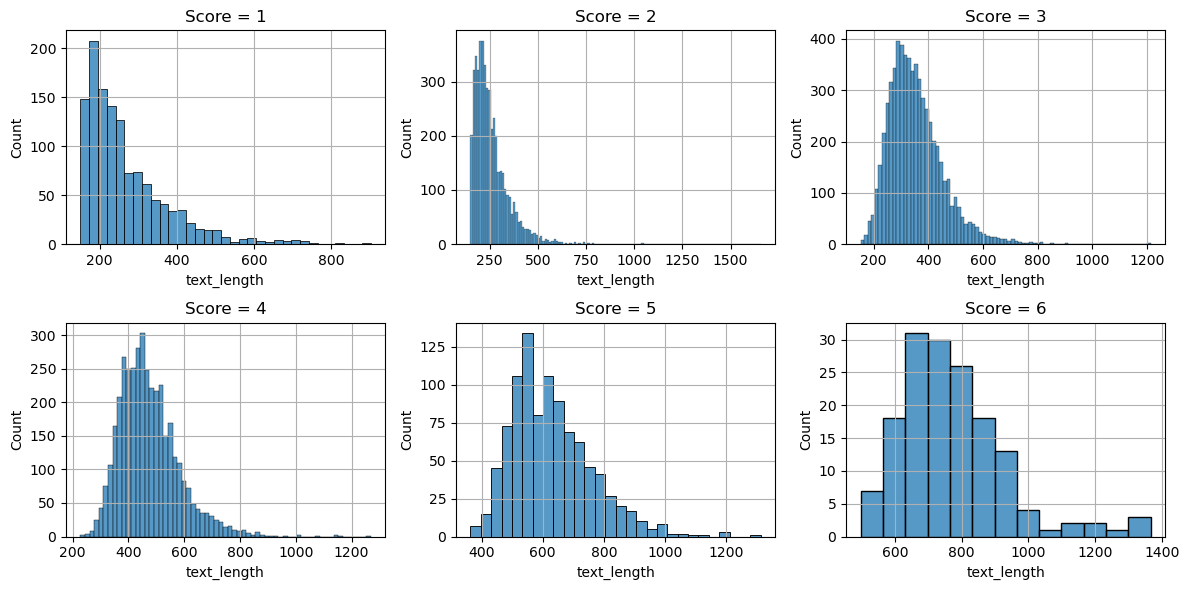

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    sns.histplot(train_csv[train_csv['score']==i+1]['text_length'], ax=ax, kde=False)
    ax.set_title(f"Score = {i+1}")
    ax.grid(True)
    
plt.tight_layout()
plt.show()

In [8]:
def remove_extra_whitespace_tabs(text):
    cleaned_text =  re.sub(r'(\s*[?]+|\xa0)\s*', ' ', text)
    cleaned_text = re.sub(r'^\s*|\s\s*', ' ', cleaned_text).strip()
    return cleaned_text

def tokenize_and_chunk(df, max_length=512):
    # Initialize the tokenizers
    results = {
        'essay_id': [],
        'label': [],
        'segment_text': [],
    }
    
    sent_tokenizer = PunktSentenceTokenizer()

    for i, row in tqdm(df.iterrows(), desc='Chunking', total=len(df)):
        text = remove_extra_whitespace_tabs(row['full_text'])
        if row['text_length'] <= max_length:
            results['essay_id'].append(row['essay_id'])
            results['label'].append(row['label'])
            results['segment_text'].append(text)
            
        else:
            sentences = sent_tokenizer.tokenize(text)
            
            # num_chunks = np.ceil(row['text_length'] / max_length).astype(int)
            # chunk_size = len(sentences) // num_chunks
            
            # chunks = []
            # for j in range(num_chunks):
            #     start_index = j * chunk_size
            #     if j == num_chunks - 1:  # Last chunk takes the remainder
            #         end_index = len(sentences)
            #     else:
            #         end_index = start_index + chunk_size
            #     chunks.append(' '.join(sentences[start_index:end_index]))
            
            # Collect sentences for the first chunk
            first_chunk = []
            word_count = 0
            for sentence in sentences:
                word_count += len(sentence.split())
                if word_count > max_length:
                    break
                first_chunk.append(sentence)
            
            # Collect sentences for the second chunk
            second_chunk = []
            word_count = 0
            for sentence in reversed(sentences):
                word_count += len(sentence.split())
                if word_count > max_length:
                    break
                second_chunk.insert(0, sentence)  # Insert at the beginning to maintain order

            num_chunks = 2
            chunks = [' '.join(first_chunk), ' '.join(second_chunk)]
            
            results['essay_id'].extend([row['essay_id']] * num_chunks)
            results['label'].extend([row['label']] * num_chunks)
            results['segment_text'].extend(chunks)
            
    return results

In [9]:
results = tokenize_and_chunk(train_csv, max_length=TRAIN_CONFIG.MAX_LENGTH)

df_results = pd.DataFrame(results)

df_results['n_tokens'] = df_results['segment_text'].apply(lambda x: len(x.split()))

df_results = df_results[df_results['n_tokens'] > 0]

df_results.sort_values('n_tokens', ascending=False).head()

# It is possible to drop samples with n_tokens<150 | n_tokens>512 

Chunking:   0%|          | 0/17307 [00:00<?, ?it/s]

,essay_id,label,segment_text,n_tokens
10675,88784a0,3,As I admit that the concept of a driverless ve...,513
698,09c0506,4,"Dear Rick Scott, Every four years on the Tuesd...",512
9543,7b0bb8f,3,"""(Duffer 10). This ban was put to good use by ...",512
6407,5266ddf,5,"Maybe that had worked in the past, when the po...",512
3715,2f73d77,1,Luke Bomberger worked a two part-time job in a...,512


In [ ]:
# for t in (df_results[df_results['essay_id'] == 'ffddf1f']['segment_text'].values):
#     pprint(t)
#     pprint("-"*50)

# print("="*10)
# pprint(train_csv[train_csv['essay_id'] == 'ffddf1f']['full_text'].values[0])

In [10]:
def tokenize_function(examples, tokenizer, max_length):
    
    tokenizer_kwargs = dict(
        padding='max_length', 
        truncation=True, 
        max_length=max_length,
        return_tensors = 'np',
        return_token_type_ids = False,
        return_attention_mask = True,
        return_length=False
    )
    
    tokens = tokenizer(examples['full_text'], **tokenizer_kwargs)
    
    return tokens


def collate_fn(batch):
    
    input_ids = [np.array(x['input_ids']) for x in batch]
    attention_mask = [np.array(x['attention_mask']) for x in batch]
    
    labels = torch.stack([torch.eye(TRAIN_CONFIG.N_CLASSES)[x['label']] for x in batch])
    
    data_dict = {
        'input_ids': torch.tensor(np.vstack(input_ids), dtype=torch.int32),
        'attention_mask': torch.tensor(np.vstack(attention_mask), dtype=torch.int8),
        'label': labels
        }
    
    return data_dict

In [11]:
embedding_tokenizer = AutoTokenizer.from_pretrained(TRAIN_CONFIG.DEBERTA_PATH, use_fast=False) 
embedding_model = AutoModel.from_pretrained(TRAIN_CONFIG.DEBERTA_PATH)

In [12]:
tokenize_fn = partial(
    tokenize_function, 
    tokenizer=embedding_tokenizer, 
    max_length=TRAIN_CONFIG.MAX_LENGTH
    )

train_ds = HF_Dataset.from_dict({
    'essay_id': df_results['essay_id'].to_list(),
    'full_text': df_results['segment_text'].to_list(),
    'label': df_results['label'].to_list()
    })

train_ds = train_ds.map(tokenize_fn, batched=True)

Map:   0%|          | 0/19993 [00:00<?, ? examples/s]

In [ ]:
# pprint(train_ds['full_text'][5678])

In [ ]:
# Test dataloader

# data_loader = DataLoader(train_ds, batch_size=16, collate_fn=collate_fn)
# for batch in data_loader:
#     data_dict = batch
    
#     print(data_dict['input_ids'].shape)
#     print(data_dict['attention_mask'].shape)
#     print(data_dict['label'].shape)
    
    # with torch.no_grad():
    #     embeddings = embedding_model(
    #         input_ids = data_dict['input_ids'],
    #         attention_mask = data_dict['attention_mask']
    #     )['last_hidden_state']
        
    # print(embeddings.shape)
    
    # break

# Model

In [13]:
# GRU model
class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, batch_rep, attention_mask):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension
        return:
            utter_rep: size (N, H)
        """
        att_logits = self.W(batch_rep).squeeze(-1)
        att_logits.masked_fill_((attention_mask==0).squeeze(-1), float('-inf'))
        att_w = self.softmax(att_logits).unsqueeze(-1)
        utter_rep = torch.sum(batch_rep * att_w, dim=1)
        return utter_rep

class DeBERTaGRUClassifier(nn.Module):
    
    def __init__(self, embedding_model, embedding_dim, n_classes):
        super(DeBERTaGRUClassifier, self).__init__()
        
        self.use_n_hidden_layers = 2
        self.mlp_hidden_size = embedding_dim * (self.use_n_hidden_layers + 1)
        
        self.berta = AutoModel.from_pretrained(embedding_model)
        # self.pooling = SelfAttentionPooling(hidden_size)
        
        self.mlp = nn.Sequential(
            nn.Linear(self.mlp_hidden_size, self.mlp_hidden_size//2),
            nn.SiLU(),
            nn.Linear(self.mlp_hidden_size//2, n_classes)
        )
        
    def forward(self, input_ids, attention_mask):
        
        # get embeddings from berta
        berta_outputs = self.berta(
            input_ids = input_ids,
            attention_mask = attention_mask,
            output_hidden_states=True
        )
        hidden_states = berta_outputs['hidden_states']
        
        # embeddings = berta_outputs['last_hidden_state']
        embeddings = torch.cat(hidden_states[ -(self.use_n_hidden_layers+1) : ], dim=-1)
        embeddings.masked_fill_((attention_mask==0).unsqueeze(-1), float("-inf"))
        embeddings = embeddings.permute(0, 2, 1)
        
        # pass pooling
        # pooled_hidden_state = self.pooling(embeddings)
        pooled_hidden_state = F.max_pool1d(embeddings, kernel_size=embeddings.size(-1)).squeeze(-1)
        
        logits = self.mlp(pooled_hidden_state)
        
        output = {
            'logits': logits,
            'hidden_state': pooled_hidden_state
        }
        
        return output

In [14]:
# # Test Model

# model = DeBERTaGRUClassifier(
#         TRAIN_CONFIG.DEBERTA_PATH, 
#         embedding_dim=TRAIN_CONFIG.EMBEDDING_SIZE, 
#         n_classes=TRAIN_CONFIG.N_CLASSES
#     )

# data_loader = DataLoader(train_ds, batch_size=16, collate_fn=collate_fn)

# # model.to(DEVICE)
# for data_dict in data_loader:
#     input_ids = data_dict['input_ids']#.to(DEVICE)
#     attention_mask = data_dict['attention_mask']#.to(DEVICE)
#     model_output = model(input_ids, attention_mask)
#     print("Model output logits shape: ", model_output['logits'].shape)
#     print("Model output hidden_state shape: ", model_output['hidden_state'].shape)
    
#     input_ids.detach().cpu() 
#     attention_mask.detach().cpu()
#     del input_ids, attention_mask
#     gc.collect()
#     torch.cuda.empty_cache()
    
#     break

# Model Training

### Define Loss

In [15]:
class OrdinalCrossEntropyLoss(nn.Module):
    def __init__(self, n_class, weights=None, order=2, epsilon=1e-13, device='cpu'):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.a = order
        self.epsilon = epsilon
        self.device = device

        d_matrix = (torch.arange(n_class, device=device).unsqueeze(0) - 
                    torch.arange(n_class, device=device).unsqueeze(1)).abs()
        
        if weights is not None:
            w_matrix = (torch.tensor(weights, device=device).unsqueeze(0) +
                        torch.tensor(weights, device=device).unsqueeze(1)).float()
            c_matrix = (d_matrix.float().pow(self.a) + 1) * w_matrix
        else:
            c_matrix = d_matrix.float().pow(self.a)
        
        self.register_buffer('C', c_matrix)
        
    def forward(self, y_pred, y_true):
        # select corresponding rows from D
        distances = torch.matmul(y_true.float(), self.C)
        probas = torch.softmax(y_pred, dim=1)
        loss = -torch.sum(torch.log(self.epsilon + 1 - probas) * distances , dim=1)
        
        return loss.mean()


class CohenKappa:
    def __init__(self, weights='quadratic'):
        self.weights = weights

    def __call__(self, y_pred, y_true):
        """
        Calculate Cohen's Kappa score.
        :param y_pred: logits or probability -> [B, n_class].
        :param y_true: one-hot code of true labels  -> [B, n_class].
        :return: kappa score.
        """
        y_pred_classes = torch.argmax(y_pred, dim=1)
        y_true_classes = torch.argmax(y_true, dim=1)
        kappa = cohen_kappa_score(
            y_true_classes.cpu().numpy(), 
            y_pred_classes.cpu().numpy(), 
            weights=self.weights
            )
        
        return kappa

In [16]:
# # test loss functions
# n_sample = 16
# n_class = 6
# identity_matrix = torch.eye(n_class)

# y_true = torch.randint(0, n_class, size=(n_sample, 1))
# y_true = torch.matmul(identity_matrix[y_true.squeeze()], identity_matrix)

# loss_fn = OrdinalCrossEntropyLoss(n_class=6, weights=TRAIN_CONFIG.USE_SCORE_WEIGHTS)
# kappa_fn = CohenKappa(weights='quadratic')

# print("Test Loss Functions: ")
# for i in range(3):
#     y_logits = torch.randn(n_sample, n_class) 
#     ordinal_ce = loss_fn(y_logits, y_true).numpy()
#     kappa_coeff = kappa_fn(torch.softmax(y_logits, dim=1), y_true)
#     print(f"{i}: Ordinal CE Loss = {ordinal_ce:.6f}, Kappa = {kappa_coeff:.6f}", )

### Train Functions

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class Trainer:

    def __init__(self, model, loss_fn, evel_fn, config):

        self.model = model
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = loss_fn
        self.loss_fn.to(self.device)
        
        self.eval_fn = evel_fn
        
    def train(self, train_loader, valid_loader, print_epoch_freq=50, from_checkpoint=None, use_tqdm=True):

        self.optimizer = AdamW(self.model.parameters(), lr=1e-3, weight_decay=self.config.WEIGHT_DECAY)

        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=self.config.MAX_LR,
            epochs=self.config.EPOCHS,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=self.config.LR_FINAL_DIV,
        )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("-inf")
        loss_records = {"train": [], "valid": []}
        
        if use_tqdm:
            pbar = tqdm(range(self.config.EPOCHS), total=self.config.EPOCHS, unit="epoch", leave=True, desc="Training Progress")
        else:
            pbar = range(self.config.EPOCHS)
            
        for epoch in pbar:
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True, use_tqdm=use_tqdm)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False, use_tqdm=use_tqdm)
            
            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch
            
            if (epoch % print_epoch_freq == 0) or (epoch == (self.config.EPOCHS - 1)):
                print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f} - Elapsed Time: {elapsed:.2f}s")
                
            # if valid_loss < best_loss:
            if valid_loss > best_loss:
                best_loss = valid_loss
                best_weights = self.model.state_dict()
                best_preds = valid_preds
                print(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")
             
        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True, use_tqdm=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.AMP)
        loss_meter = AverageMeter()
        labels_record, predicts_record = [], []

        start = time()
        
        if use_tqdm:
            pbar = tqdm(enumerate(dataloader), total=len_loader, desc=mode, unit="batch")
        else:
            pbar = enumerate(dataloader)
            
        for step, data_dict in pbar:
            
            input_ids = data_dict['input_ids'].to(DEVICE)
            attention_mask = data_dict['attention_mask'].to(DEVICE)
            labels = data_dict['label'].to(DEVICE)
            
            if is_train:
                with autocast(enabled=self.config.AMP):
                    model_output = self.model(input_ids, attention_mask)
                    logits = model_output['logits']
                    train_loss = self.loss_fn(logits, labels)
                    
                if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                    train_loss = train_loss / self.config.GRADIENT_ACCUMULATION_STEPS
                    
                scaler.scale(train_loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.MAX_GRAD_NORM)
                if (step + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
                    
                loss_meter.update(train_loss.item())
                
            else:
                with torch.no_grad():
                    model_output = self.model(input_ids, attention_mask)
                    logits = model_output['logits']
                    # loss = self.loss_fn(logits, labels)
                    # loss = self.eval_fn(F.softmax(logits, dim=1), labels)
                # if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                #     loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                
                predicts_record.append(logits.to('cpu'))
                labels_record.append(labels.to('cpu'))
                
                eval_loss = self.eval_fn(
                    F.softmax(torch.cat(predicts_record), dim=1),
                    torch.cat(labels_record)
                )
            
            end = time()
            
            if self.config.PRINT_FREQ:
                if (step % self.config.PRINT_FREQ == 0) or (step == (len_loader - 1)):
                    lr = self.scheduler.get_last_lr()[0]
                    info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} "
                    if is_train:
                        info += f"Loss: {loss_meter.avg:.4f} Grad: {grad_norm:.4f} LR: {lr:.4e}"
                    else:
                        info += f"Loss: {eval_loss:.4f}"
                    info += f" | Elapse: {end - start:.2f}s"
                    print(info)

        if is_train:
            return loss_meter.avg, None
        else:
            eval_loss = self.eval_fn(
                F.softmax(torch.cat(predicts_record), dim=1),
                torch.cat(labels_record)
                )
            
            predicts_record = np.concatenate([p.numpy() for p in predicts_record], axis=0)
            return eval_loss, predicts_record


### Training Loop

In [18]:
k_folds = 5
skf = StratifiedKFold(n_splits=TRAIN_CONFIG.N_SPLITS, shuffle=False)

df_folds = pd.DataFrame({
    'essay_id': train_csv['essay_id'],
    'score': train_csv['label'],
    'fold': 0
    })

# df_folds = pd.DataFrame({
#     'example_id': range(len(train_ds)), 
#     'essay_id': train_ds['essay_id'],
#     'score': train_ds['label'], 
#     'fold': 0
#     })

for fold, (train_idx, val_idx) in enumerate(skf.split(df_folds, df_folds['score'])):
    df_folds.loc[val_idx, 'fold'] = fold

display(df_folds['fold'].value_counts())

fold
0    3462
1    3462
2    3461
3    3461
4    3461
Name: count, dtype: int64

In [19]:
def prepare_data(df_folds, fold, train_ds):
    train_examples = df_folds[df_folds['fold'] != fold]['essay_id'].tolist()
    valid_examples = df_folds[df_folds['fold'] == fold]['essay_id'].tolist()
    train_folds = train_ds.filter(lambda x: x['essay_id'] in train_examples)
    valid_folds = train_ds.filter(lambda x: x['essay_id'] in valid_examples)
    return train_folds, valid_folds


def suggest_weights(trial, num_classes=TRAIN_CONFIG.N_CLASSES):
    weights = [trial.suggest_float(f'weight_{i}', 0.1, 10.0) for i in range(num_classes)]
    return np.array(weights)


def plot_cm(oof, loss_val, target_cols, predict_cols, save_to=None):
    
    oof['true_score'] = oof[target_cols].idxmax(axis=1).str.split('_').str[-1].astype(int) + 1
    oof['pred_score'] = oof[predict_cols].idxmax(axis=1).str.split('_').str[-1].astype(int) + 1
    # Plotting the normalized confusion matrix
    cm = confusion_matrix(oof['true_score'].values, oof['pred_score'].values, normalize='true')
    fig = plt.figure()
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Kappa Coeff = {loss_val}')
    
    if save_to:
        plt.savefig(save_to)
    
    plt.show()
    
    
def plot_loss_record(loss_history, final_loss, start_at=0, save_to=None):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    ax2 = ax1.twinx()
    for i, loss in enumerate(loss_history):
        ax1.plot(np.arange(start_at, len(loss['train'])), loss['train'][start_at:], "-",   label=f'Train_{i}')
        ax2.plot(np.arange(start_at, len(loss['valid'])), loss['valid'][start_at:], ".--", label=f'Valid_{i}')
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss")
    ax2.set_ylabel("Valid Loss (Dashed)")
    ax1.set_title(f"Final Eval-Loss: {final_loss:.4f}")
    ax1.legend(loc='lower left', bbox_to_anchor=[1.15, 0])
    ax2.legend(loc='upper left', bbox_to_anchor=[1.15, 1])
    
    if save_to:
        plt.savefig(save_to)
    
    fig.tight_layout()
    plt.show()


def run_training(train_ds, df_folds, weights=TRAIN_CONFIG.USE_SCORE_WEIGHTS, logger=None, display_cm=False, display_loss=True, use_tqdm=False):
    
    # Define loss and eval functions
    loss_fn = OrdinalCrossEntropyLoss(n_class=TRAIN_CONFIG.N_CLASSES, weights=weights, order=2, epsilon=1e-13, device=DEVICE)
    eval_fn = CohenKappa(weights='quadratic')
    
    oof, loss_history = pd.DataFrame(), []
        
    target_cols = [f"score_{i}" for i in range(TRAIN_CONFIG.N_CLASSES)]
    predict_cols = [f"predict_{i}" for i in range(TRAIN_CONFIG.N_CLASSES)]
    
    loader_kwargs = {
        "batch_size": TRAIN_CONFIG.BATCH_SIZE,
        "num_workers": TRAIN_CONFIG.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
        'collate_fn': collate_fn
    }
    
    for fold_id in range(TRAIN_CONFIG.N_SPLITS):
        tik = time()
        
        train_folds, valid_folds = prepare_data(df_folds, fold_id, train_ds)
        train_loader = DataLoader(train_folds, drop_last=True,  **loader_kwargs)
        valid_loader = DataLoader(valid_folds, drop_last=False, **loader_kwargs)
            
        model = DeBERTaGRUClassifier(
            TRAIN_CONFIG.DEBERTA_PATH, 
            embedding_dim=TRAIN_CONFIG.EMBEDDING_SIZE, 
            n_classes=TRAIN_CONFIG.N_CLASSES
        )
        
        trainer = Trainer(model, loss_fn, eval_fn, TRAIN_CONFIG)
        
        best_weights, best_preds, loss_records = trainer.train( 
            train_loader, 
            valid_loader, 
            print_epoch_freq=TRAIN_CONFIG.PRINT_EPOCH_FREQ, 
            from_checkpoint=None,
            use_tqdm=use_tqdm
            )
        
        loss_history.append(loss_records)
        
        df_valid = pd.DataFrame({'essay_id': valid_folds['essay_id'], 'fold': fold})
        df_valid[target_cols] = [np.eye(TRAIN_CONFIG.N_CLASSES)[x['label']] for x in valid_folds]
        df_valid[predict_cols] = best_preds
        
        oof = pd.concat([oof, df_valid], axis=0).reset_index(drop=True)
        
        save_model_name = f"{TRAIN_CONFIG.MODEL_NAME}_fold_{fold_id}"
        torch.save(best_weights, os.path.join(TRAIN_CONFIG.OUTPUT_DIR, save_model_name + ".pth"))

        del train_folds, valid_folds, train_loader, valid_loader
        torch.cuda.empty_cache()
        gc.collect()
        
        if logger is not None:
            valid_loss_fold = eval_fn(
                torch.tensor(oof[predict_cols].values),
                torch.tensor(oof[target_cols].values)
            )
            logger.info(f"Fold {fold_id} | Time: {(time() - tik)/60:.2f}min | Overall Evaluation Loss: {valid_loss_fold:.4f}")
            
        if display_cm:
            plot_cm(oof, valid_loss_fold, target_cols, predict_cols, save_to=os.path.join(TRAIN_CONFIG.OUTPUT_DIR, f"{save_model_name}_cm.jpg"))
            
    # Summarize the final results
    valid_loss = eval_fn(
        torch.tensor(oof[predict_cols].values),
        torch.tensor(oof[target_cols].values)
    )
    
    if display_loss:
        plot_loss_record(loss_history, valid_loss, start_at=0, save_to=os.path.join(TRAIN_CONFIG.OUTPUT_DIR, f"{save_model_name}_loss.jpg"))
    
    # Save the final oof predictions
    oof.to_csv(f"{TRAIN_CONFIG.OUTPUT_DIR}/{TRAIN_CONFIG.MODEL_NAME}_oof.csv", index=False)
    
    result = {
        'oof': oof,
        'loss_history': loss_history,
        'valid_loss': valid_loss
    }
     
    return result

################################### TRAIN_CONFIG ###################################
MODEL_NAME: DeBerta_base_MaxPool_HiddenStates
OUTPUT_DIR: ./working
N_CLASSES: 6
N_SPLITS: 5
MAX_LENGTH: 512
EMBEDDING_SIZE: 768
DEBERTA_PATH: ./input/huggingfacedebertav3variants/deberta-v3-base
USE_SCORE_WEIGHTS: [1.  5.  6.  5.  2.  0.5]
BATCH_SIZE: 8
EPOCHS: 5
MAX_LR: 1e-05
LR_FINAL_DIV: 1000
PRINT_EPOCH_FREQ: 1
NUM_WORKERS: 0
AMP: True
GRADIENT_ACCUMULATION_STEPS: 1
PRINT_FREQ: None
WEIGHT_DECAY: 0.02
MAX_GRAD_NORM: 10000000.0
SEED: 2046
################################################################################


Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 - Train Loss: 25.1648 - Valid Loss: 0.7674 - Elapsed Time: 636.82s
- Epoch 1: Best model found with loss = 0.7674.
Epoch 2 - Train Loss: 20.8808 - Valid Loss: 0.7887 - Elapsed Time: 642.84s
- Epoch 2: Best model found with loss = 0.7887.
Epoch 3 - Train Loss: 19.9312 - Valid Loss: 0.7885 - Elapsed Time: 642.08s
Epoch 4 - Train Loss: 19.2499 - Valid Loss: 0.7975 - Elapsed Time: 640.33s
- Epoch 4: Best model found with loss = 0.7975.
Epoch 5 - Train Loss: 18.8251 - Valid Loss: 0.8147 - Elapsed Time: 641.24s
- Epoch 5: Best model found with loss = 0.8147.
Fold 0 | Time: 53.62min | Overall Evaluation Loss: 0.8147


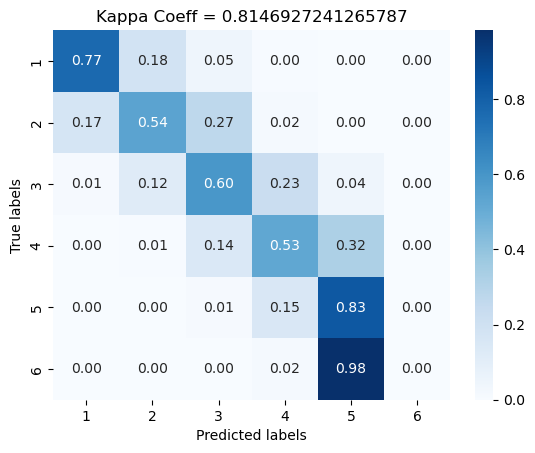

Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 - Train Loss: 25.3698 - Valid Loss: 0.7517 - Elapsed Time: 639.19s
- Epoch 1: Best model found with loss = 0.7517.
Epoch 2 - Train Loss: 21.0717 - Valid Loss: 0.7791 - Elapsed Time: 640.71s
- Epoch 2: Best model found with loss = 0.7791.
Epoch 3 - Train Loss: 20.1738 - Valid Loss: 0.7786 - Elapsed Time: 642.07s
Epoch 4 - Train Loss: 19.4683 - Valid Loss: 0.7995 - Elapsed Time: 640.84s
- Epoch 4: Best model found with loss = 0.7995.
Epoch 5 - Train Loss: 19.0428 - Valid Loss: 0.8139 - Elapsed Time: 643.17s
- Epoch 5: Best model found with loss = 0.8139.
Fold 1 | Time: 53.66min | Overall Evaluation Loss: 0.8143


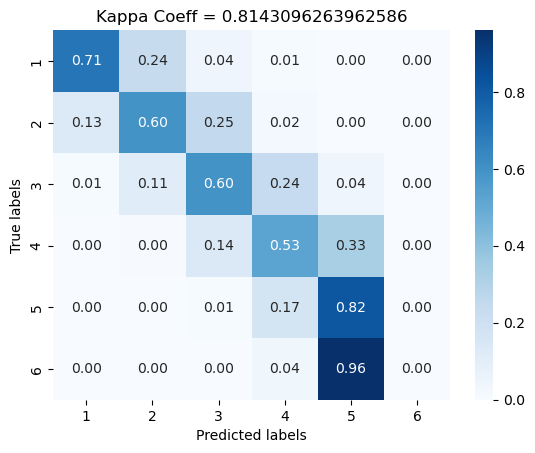

Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 - Train Loss: 26.2561 - Valid Loss: 0.6687 - Elapsed Time: 638.49s
- Epoch 1: Best model found with loss = 0.6687.
Epoch 2 - Train Loss: 21.6948 - Valid Loss: 0.7767 - Elapsed Time: 643.04s
- Epoch 2: Best model found with loss = 0.7767.
Epoch 3 - Train Loss: 20.1465 - Valid Loss: 0.7985 - Elapsed Time: 641.77s
- Epoch 3: Best model found with loss = 0.7985.
Epoch 4 - Train Loss: 19.4458 - Valid Loss: 0.7956 - Elapsed Time: 643.91s
Epoch 5 - Train Loss: 18.9600 - Valid Loss: 0.8110 - Elapsed Time: 644.35s
- Epoch 5: Best model found with loss = 0.8110.
Fold 2 | Time: 53.75min | Overall Evaluation Loss: 0.8132


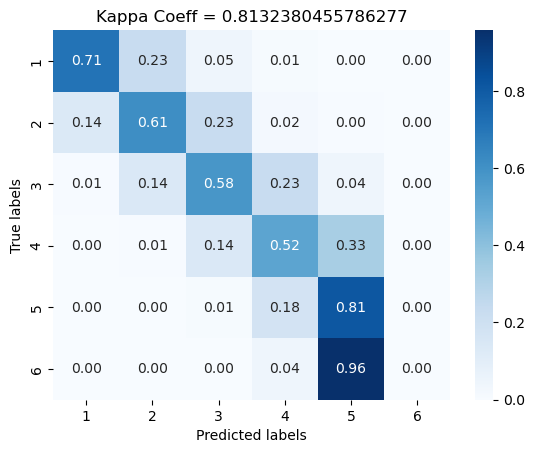

Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 - Train Loss: 26.3112 - Valid Loss: 0.6676 - Elapsed Time: 643.91s
- Epoch 1: Best model found with loss = 0.6676.
Epoch 2 - Train Loss: 23.1940 - Valid Loss: 0.7165 - Elapsed Time: 647.11s
- Epoch 2: Best model found with loss = 0.7165.
Epoch 3 - Train Loss: 22.5153 - Valid Loss: 0.7317 - Elapsed Time: 643.53s
- Epoch 3: Best model found with loss = 0.7317.
Epoch 4 - Train Loss: 22.0562 - Valid Loss: 0.7711 - Elapsed Time: 640.48s
- Epoch 4: Best model found with loss = 0.7711.
Epoch 5 - Train Loss: 21.7077 - Valid Loss: 0.7829 - Elapsed Time: 642.93s
- Epoch 5: Best model found with loss = 0.7829.
Fold 3 | Time: 53.86min | Overall Evaluation Loss: 0.8068


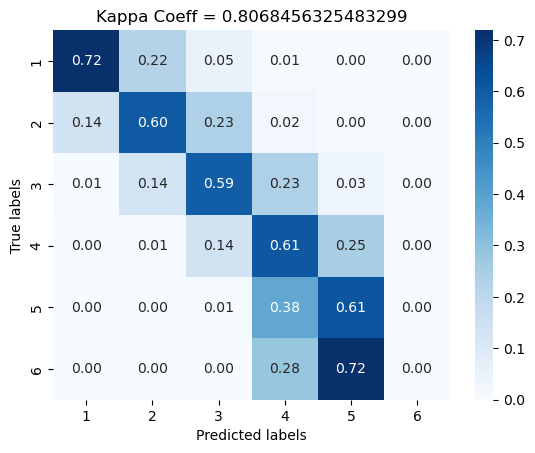

Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19993 [00:00<?, ? examples/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 - Train Loss: 25.7527 - Valid Loss: 0.6989 - Elapsed Time: 641.29s
- Epoch 1: Best model found with loss = 0.6989.
Epoch 2 - Train Loss: 20.8693 - Valid Loss: 0.7565 - Elapsed Time: 642.89s
- Epoch 2: Best model found with loss = 0.7565.
Epoch 3 - Train Loss: 19.9576 - Valid Loss: 0.7857 - Elapsed Time: 643.01s
- Epoch 3: Best model found with loss = 0.7857.
Epoch 4 - Train Loss: 19.2653 - Valid Loss: 0.7988 - Elapsed Time: 643.76s
- Epoch 4: Best model found with loss = 0.7988.
Epoch 5 - Train Loss: 18.8279 - Valid Loss: 0.8144 - Elapsed Time: 644.82s
- Epoch 5: Best model found with loss = 0.8144.
Fold 4 | Time: 53.83min | Overall Evaluation Loss: 0.8084


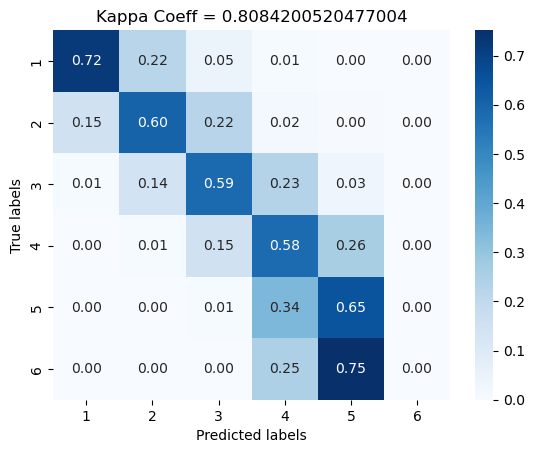

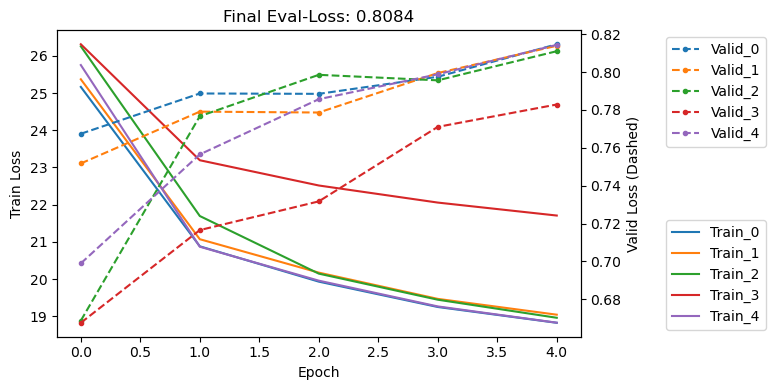

In [20]:
logger = get_logger(log_file=f"{TRAIN_CONFIG.OUTPUT_DIR}/{TRAIN_CONFIG.MODEL_NAME}.log")

# log TRAIN_CONFIG
logger.info(f"{'#'*35} TRAIN_CONFIG {'#'*35}")
for k, v in TRAIN_CONFIG.__dict__.items():
    if '__' not in k:
        logger.info(f"{k}: {v}")

logger.info(f"{'#'*80}")

# Run Training
result = run_training(train_ds, df_folds, weights=TRAIN_CONFIG.USE_SCORE_WEIGHTS, logger=logger, display_cm=True, display_loss=True)

In [ ]:
oof = result['oof']
display(oof.head(10))

In [ ]:
loss_history = result['loss_history']

start_at = 0
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax2 = ax1.twinx()
for i, loss in enumerate(loss_history):
    ax1.plot(np.arange(start_at, len(loss['train'])), loss['train'][start_at:], "-",   label=f'Train_{i}')
    ax2.plot(np.arange(start_at, len(loss['valid'])), loss['valid'][start_at:], ".--", label=f'Valid_{i}')
    
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss")
ax2.set_ylabel("Valid Loss (Dashed)")
ax1.legend(loc='lower left', bbox_to_anchor=[1.15, 0])
ax2.legend(loc='upper left', bbox_to_anchor=[1.15, 1])

fig.tight_layout()
plt.show()

In [ ]:
predict_cols = [f"predict_{i}" for i in range(TRAIN_CONFIG.N_CLASSES)]
target_cols = [f"score_{i}" for i in range(TRAIN_CONFIG.N_CLASSES)]

oof['true_score'] = oof[target_cols].apply(lambda x: np.argmax(x), axis=1)
oof['pred_score'] = oof[predict_cols].apply(lambda x: np.argmax(softmax(x)), axis=1)

cm = confusion_matrix(oof['true_score'].values, oof['pred_score'].values, normalize='true')
# Plotting the normalized confusion matrix
fig = plt.figure()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
predict_cols = [f"predict_{i}" for i in range(TRAIN_CONFIG.N_CLASSES)]
target_cols = [f"score_{i}" for i in range(TRAIN_CONFIG.N_CLASSES)]

df_1 = oof.groupby('essay_id')[predict_cols+target_cols].mean() 

df_1['true_score'] = df_1[target_cols].apply(lambda x: np.argmax(x), axis=1)
df_1['pred_score'] = df_1[predict_cols].apply(lambda x: np.argmax(softmax(x)), axis=1)

# kappa score
kappa_score = cohen_kappa_score(df_1['true_score'].values, df_1['pred_score'].values, weights='quadratic')
print(f"Overall Quadratic Weighted Kappa: {kappa_score:.6f}")

cm = confusion_matrix(df_1['true_score'].values, df_1['pred_score'].values, normalize='true')
# Plotting the normalized confusion matrix
fig = plt.figure()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
select_rows = oof.sample(len(axes.flatten()))

for ax_id, (i, _row) in enumerate(select_rows.iterrows()):
    ax = axes.flat[ax_id]
    predict_probs = softmax(_row[predict_cols].values.astype(np.float32))
    ax.plot(np.arange(1, 7), predict_probs, 'o-')
    ax.plot(np.arange(1, 7), _row[target_cols].values.astype(np.float32), 'ro--')
    ax.set_xlabel('Score')
    ax.set_ylabel('Probability')
    ax.set_title(f"Essay ID: {_row['essay_id']}")

plt.tight_layout()
plt.show()